In [ ]:
#df['date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']], format='%Y %m %d')
#print(df['date'])

##K-Means Clustering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings

warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

ALLSKY_KT = Kejernihan Langit
T2M = Temperatur
TS =
PRECTOTCORR = Curah Hujan
PS = Rata - Rata Tekanan Permukaan Bumi
WS10M = Kecepatan angin rata2 10 m

In [ ]:
data = pd.read_excel('/content/DATA FIX KLASIFIKASI MACHINE LEARNING.xlsx')
data

,DATE,Y1,Y2,Y3,Y4,Y5,Y6
0,2017-01-01 00:00:00,0.34,19.01,18.83,0.81,27.45,87.77
1,2017-02-01 00:00:00,0.45,18.76,18.78,0.73,14.49,87.79
2,2017-03-01 00:00:00,0.42,19.45,19.39,0.99,38.89,87.71
3,2017-04-01 00:00:00,0.19,17.95,17.90,1.70,15.65,87.64
4,2017-05-01 00:00:00,0.30,18.47,18.47,2.10,40.10,87.58
...,...,...,...,...,...,...,...
2551,27/12/2023,0.24,20.40,20.40,0.84,43.38,88.03
2552,28/12/2023,0.52,19.74,19.74,0.95,28.60,87.97
2553,29/12/2023,0.45,20.01,19.90,1.06,26.78,87.93
2554,30/12/2023,0.61,19.66,19.67,0.66,87.32,87.89


In [ ]:
data.head()

,DATE,Y1,Y2,Y3,Y4,Y5,Y6
0,2017-01-01 00:00:00,0.34,19.01,18.83,0.81,27.45,87.77
1,2017-02-01 00:00:00,0.45,18.76,18.78,0.73,14.49,87.79
2,2017-03-01 00:00:00,0.42,19.45,19.39,0.99,38.89,87.71
3,2017-04-01 00:00:00,0.19,17.95,17.90,1.70,15.65,87.64
4,2017-05-01 00:00:00,0.30,18.47,18.47,2.10,40.10,87.58


In [ ]:
data.shape

(2556, 7)

In [ ]:
data.dtypes

DATE     object
Y1      float64
Y2      float64
Y3      float64
Y4      float64
Y5      float64
Y6      float64
dtype: object

In [ ]:
data.isnull().sum()

DATE    0
Y1      0
Y2      0
Y3      0
Y4      0
Y5      0
Y6      0
dtype: int64

#### Mengatasi Outlier

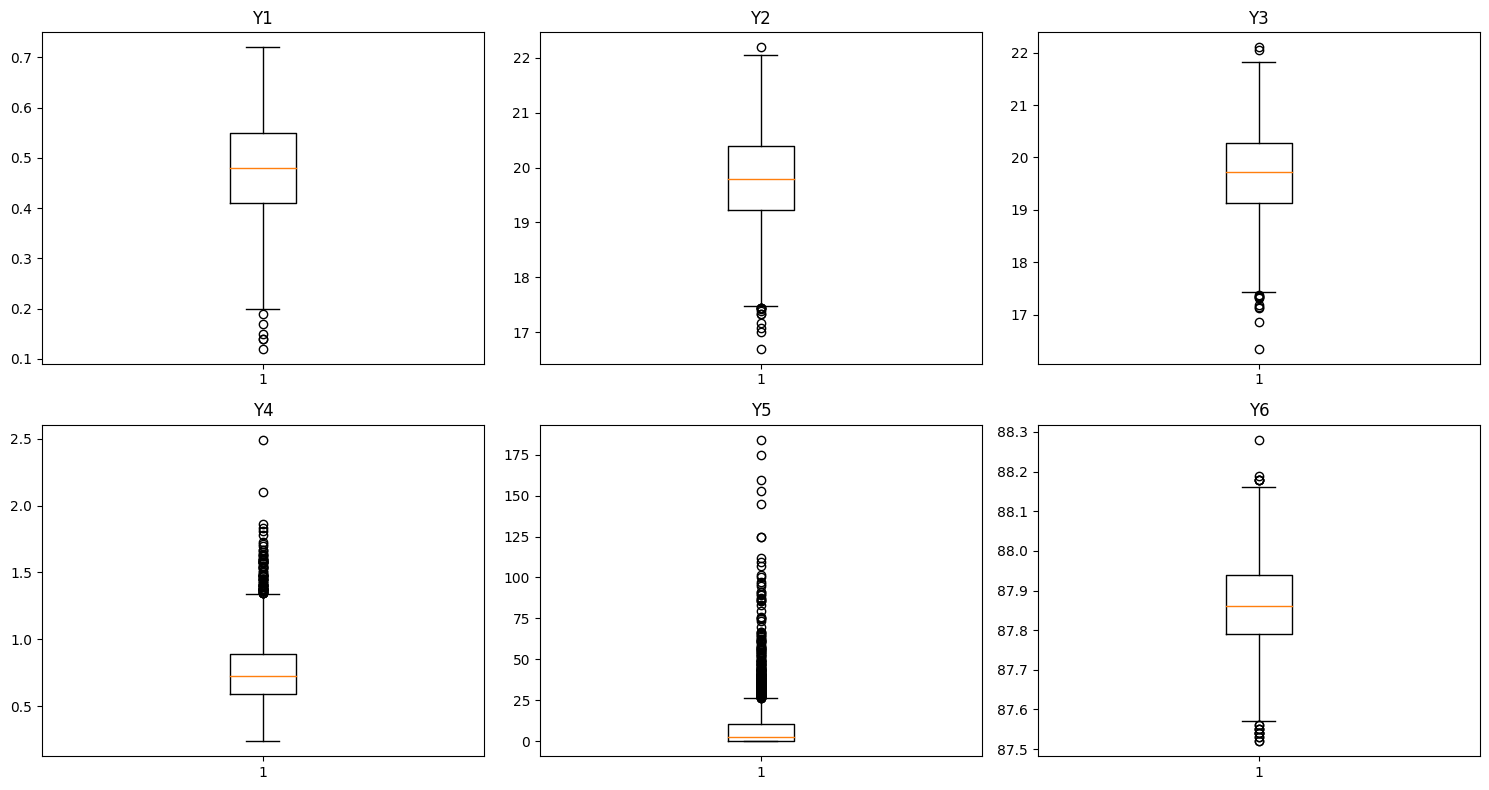

In [ ]:
numerical_col = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6"]
num_variables = len(numerical_col)
num_rows = 2  # We'll create 2 rows of subplots
num_cols = (num_variables + num_rows - 1) // num_rows  # Calculate number of columns needed

plt.figure(figsize=(15, 8))

for i, variable in enumerate(numerical_col):
    plt.subplot(num_rows, num_cols, i+1)
    plt.boxplot(data[variable], whis=1.5)
    plt.title(variable)

plt.tight_layout()
plt.show()

### K-Means Clustering

In [ ]:
x_train = data[["Y1", "Y2", "Y3", "Y4", "Y5", "Y6"]].values
x_train

array([[ 0.34, 19.01, 18.83,  0.81, 27.45, 87.77],
       [ 0.45, 18.76, 18.78,  0.73, 14.49, 87.79],
       [ 0.42, 19.45, 19.39,  0.99, 38.89, 87.71],
       ...,
       [ 0.45, 20.01, 19.9 ,  1.06, 26.78, 87.93],
       [ 0.61, 19.66, 19.67,  0.66, 87.32, 87.89],
       [ 0.57, 19.83, 19.84,  0.73, 22.69, 87.94]])

#### Mencari Jumlah k Terbaik

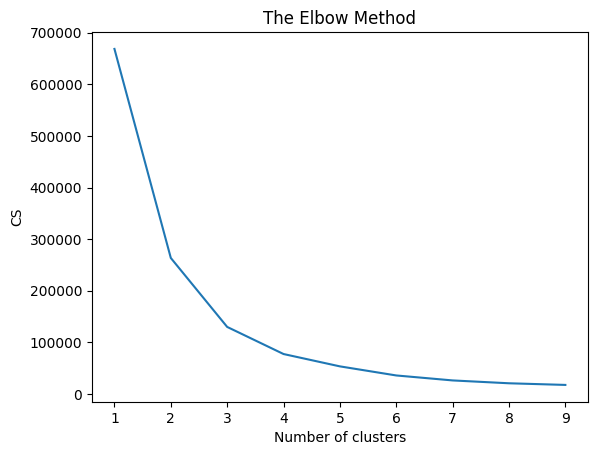

In [ ]:
# Elbow method
from sklearn.cluster import KMeans
cs = []
for i in range (1,10):
    kmeans = KMeans(n_clusters=i, init = 'k-means++',max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x_train)
    cs.append(kmeans.inertia_)
plt.plot(range(1,10), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [ ]:
# Silhouette method
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=300)
    kmeans.fit(x_train)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(x_train, cluster_labels)
    print("For n_cluster={0}, the silhoutte score is {1}".format(num_clusters, silhouette_avg))

For n_cluster=2, the silhoutte score is 0.7737495251348131
For n_cluster=3, the silhoutte score is 0.7338211019392127
For n_cluster=4, the silhoutte score is 0.6811084530336636
For n_cluster=5, the silhoutte score is 0.6542459066915248
For n_cluster=6, the silhoutte score is 0.6286462494136669
For n_cluster=7, the silhoutte score is 0.6045093215025561
For n_cluster=8, the silhoutte score is 0.5552484969543705


#### Jumlah k = 2 Terbaik

In [ ]:
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans

KMeans(n_clusters=2, random_state=0)

In [ ]:
y_cluster = kmeans.fit_predict(x_train)

In [ ]:
data['Cluster'] = y_cluster

In [ ]:
kmeans.cluster_centers_

array([[ 0.49065151, 19.7945387 , 19.7029777 ,  0.76810232,  4.73583953,
        87.86239615],
       [ 0.4105948 , 19.67843866, 19.6166171 ,  0.7730855 , 45.76066914,
        87.82973978]])

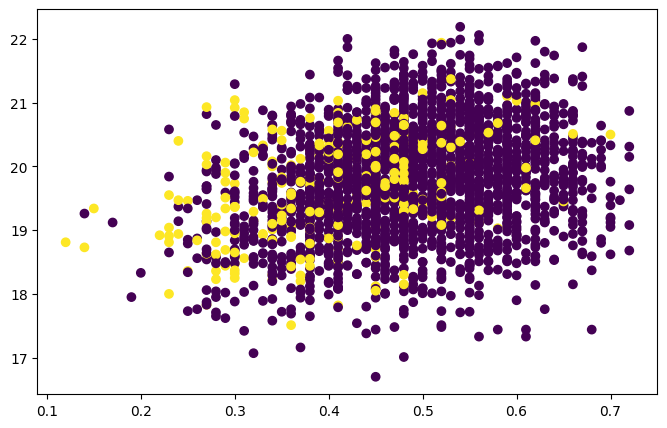

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(x_train[:,0], x_train[:,1], c = kmeans.labels_)

In [ ]:
data["Cluster"] = data["Cluster"].astype("object")

data.loc[data.Cluster==0, "Cluster"] = "TIDAK BERPOTENSI UPWELLING"
data.loc[data.Cluster==1, "Cluster"] = "BERPOTENSI UPWELLING"

In [ ]:
data.groupby(["Cluster"]).count()

,DATE,Y1,Y2,Y3,Y4,Y5,Y6
Cluster,,,,,,,
BERPOTENSI UPWELLING,269,269,269,269,269,269,269
TIDAK BERPOTENSI UPWELLING,2287,2287,2287,2287,2287,2287,2287


In [ ]:
# Mengonversi kolom DATE ke format datetime
data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce', dayfirst=True)

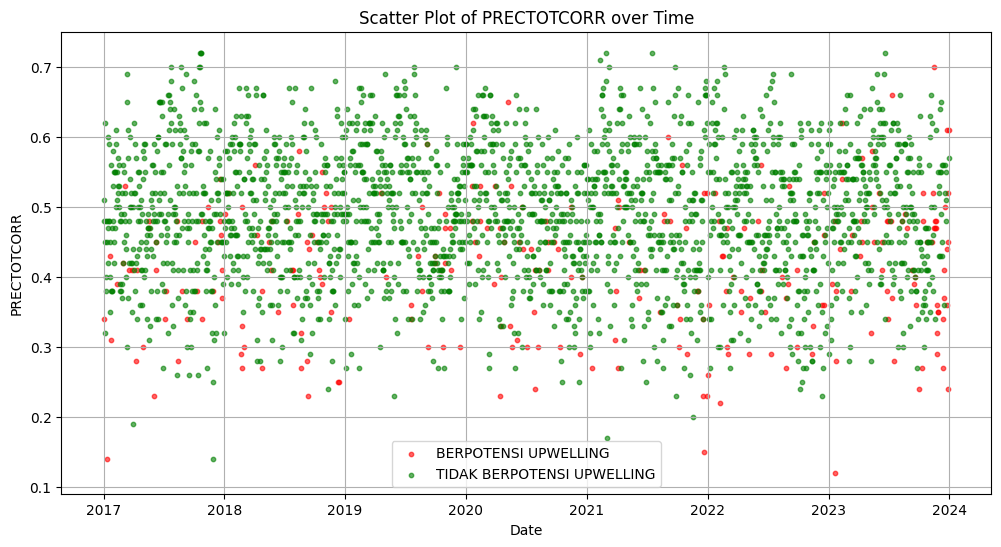

In [ ]:
# Menentukan warna berdasarkan cluster
colors = {'BERPOTENSI UPWELLING': 'red', 'TIDAK BERPOTENSI UPWELLING': 'green'}

# Membuat plot
plt.figure(figsize=(12, 6))
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['DATE'], cluster_data['Y1'],
                color=colors[cluster], label=cluster, s=10, alpha=0.6)

# Menambahkan judul dan label
plt.title('Scatter Plot of PRECTOTCORR over Time')
plt.xlabel('Date')
plt.ylabel('PRECTOTCORR')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data.groupby(["Cluster"]).describe().T

Cluster              BERPOTENSI UPWELLING     TIDAK BERPOTENSI UPWELLING
DATE count                            269                           2287
     mean   2020-11-28 02:24:32.118959104  2020-06-13 21:41:28.675120384
     min              2017-01-01 00:00:00            2017-01-02 00:00:00
     25%              2018-10-23 00:00:00            2018-09-27 12:00:00
     50%              2020-12-10 00:00:00            2020-06-14 00:00:00
     75%              2022-12-18 00:00:00            2022-03-07 12:00:00
     max              2023-12-30 00:00:00            2023-12-31 00:00:00
     std                              NaN                            NaN
Y1   count                          269.0                         2287.0
     mean                        0.410595                       0.490652
     min                             0.12                           0.14
     25%                             0.34                           0.43
     50%                             0.41                           0.49
     75%                             0.48                           0.56
     max                              0.7                           0.72
     std                          0.09662                       0.094414
Y2   count                          269.0                         2287.0
     mean                       19.678439                      19.794539
     min                            17.51                           16.7
     25%                            19.13                         19.225
     50%                            19.66                          19.81
     75%                            20.33                           20.4
     max                            21.94                          22.19
     std                         0.787524                       0.863489
Y3   count                          269.0                         2287.0
     mean                       19.616617                      19.702978
     min                            17.57                          16.35
     25%                            19.11                          19.15
     50%                            19.63                          19.73
     75%                            20.23                         20.285
     max                             21.6                           22.1
     std                         0.762275                       0.835026
Y4   count                          269.0                         2287.0
     mean                        0.773086                       0.768102
     min                              0.3                           0.24
     25%                             0.59                           0.59
     50%                             0.72                           0.73
     75%                              0.9                           0.89
     max                             2.49                           1.86
     std                         0.276718                        0.24666
Y5   count                          269.0                         2287.0
     mean                       45.760669                        4.73584
     min                             25.6                            0.0
     25%                            29.65                           0.17
     50%                            36.99                           1.96
     75%                            50.99                           7.27
     max                           183.99                          25.16
     std                        25.445232                        6.13894
Y6   count                          269.0                         2287.0
     mean                        87.82974                      87.862396
     min                            87.52                          87.52
     25%                            87.75                          87.79
     50%                            87.83                          87.87
     75%                            87.92                 

### Visualisasi Data

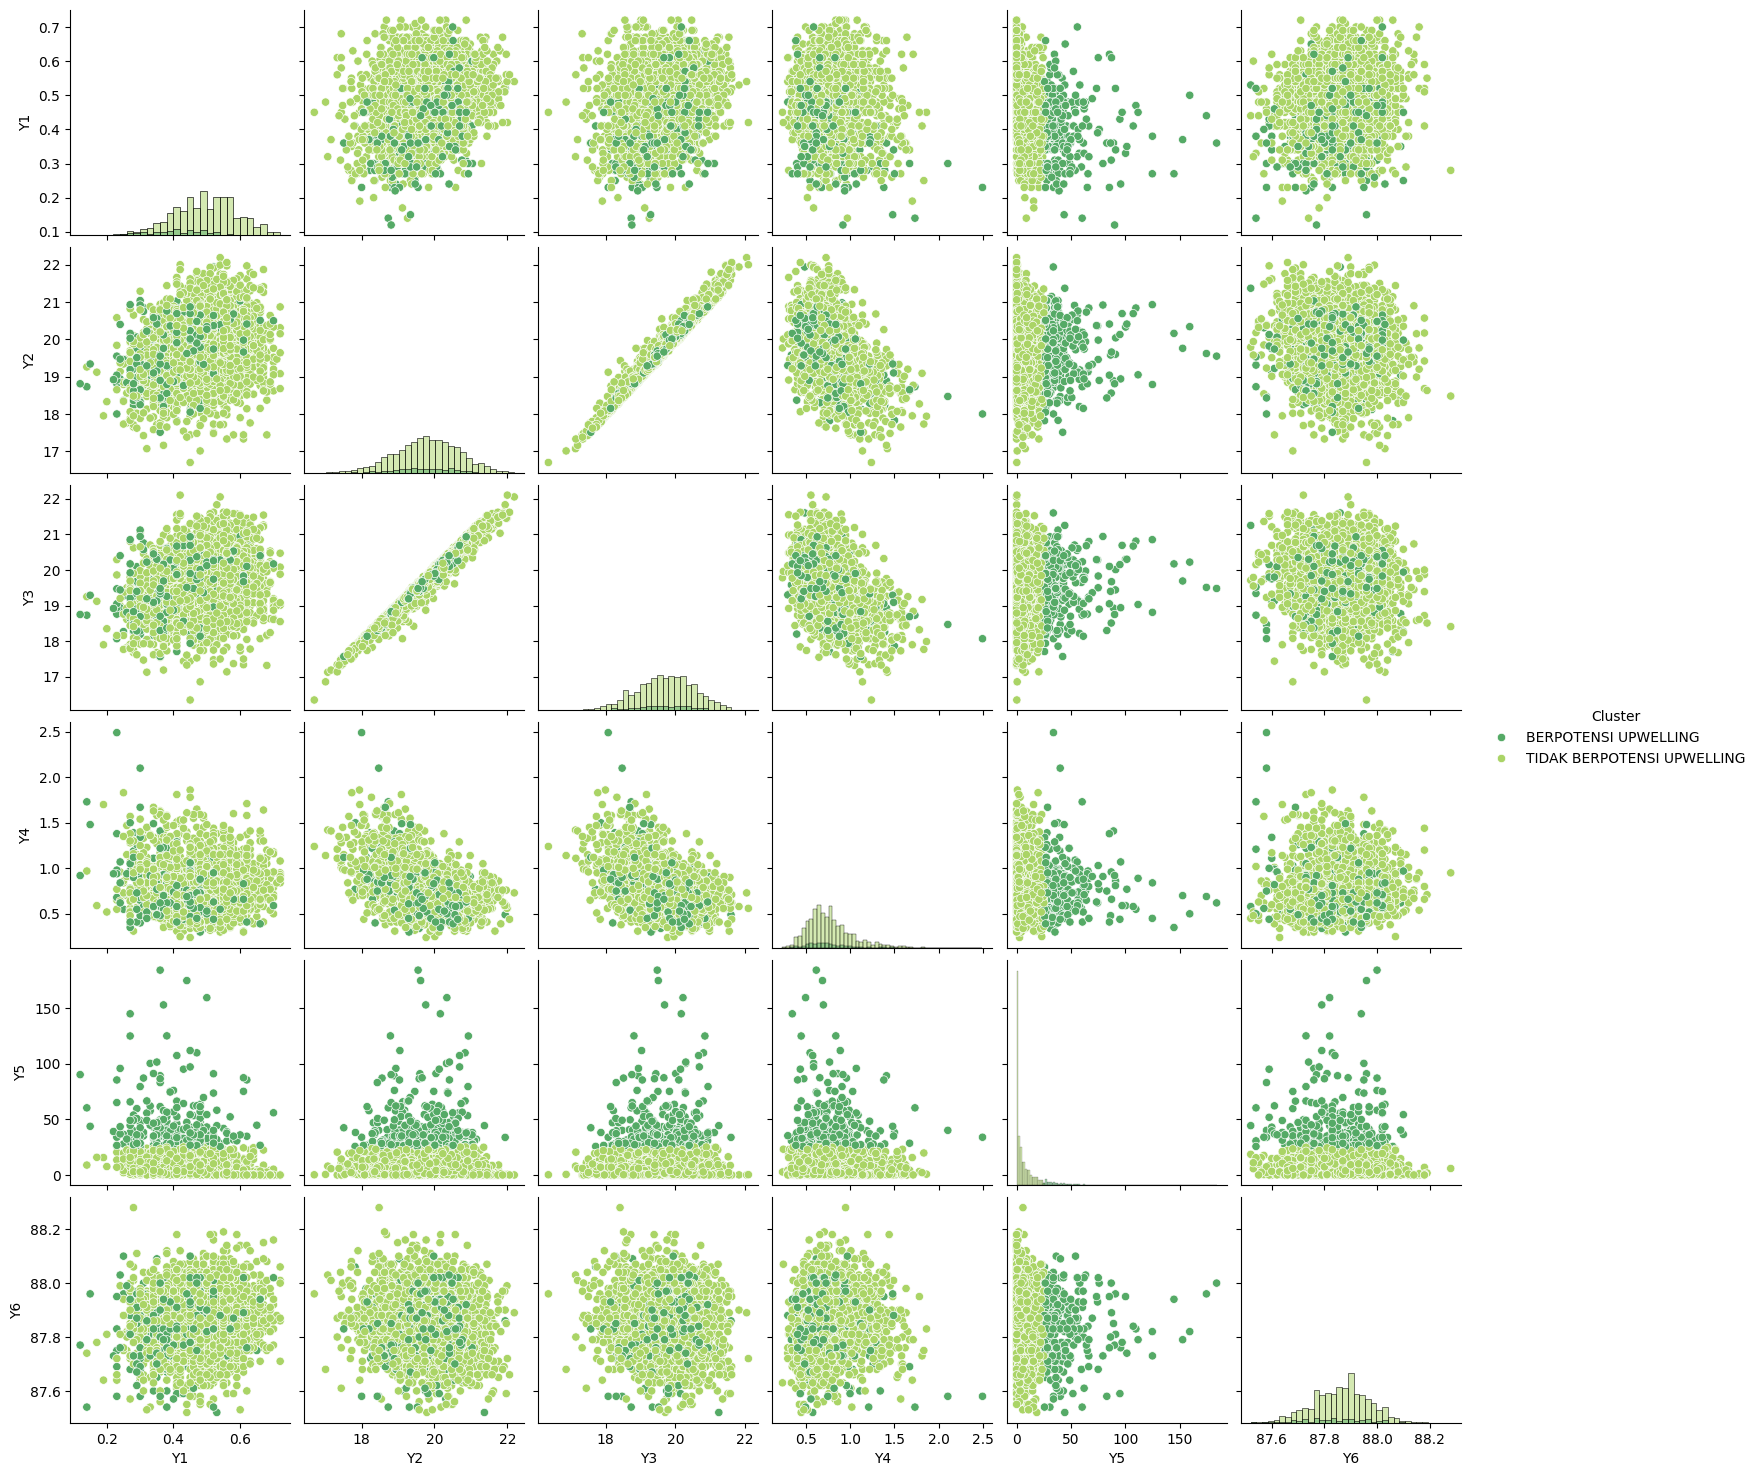

In [ ]:
sns.pairplot(data, hue = "Cluster", diag_kind = "hist", palette = "summer")

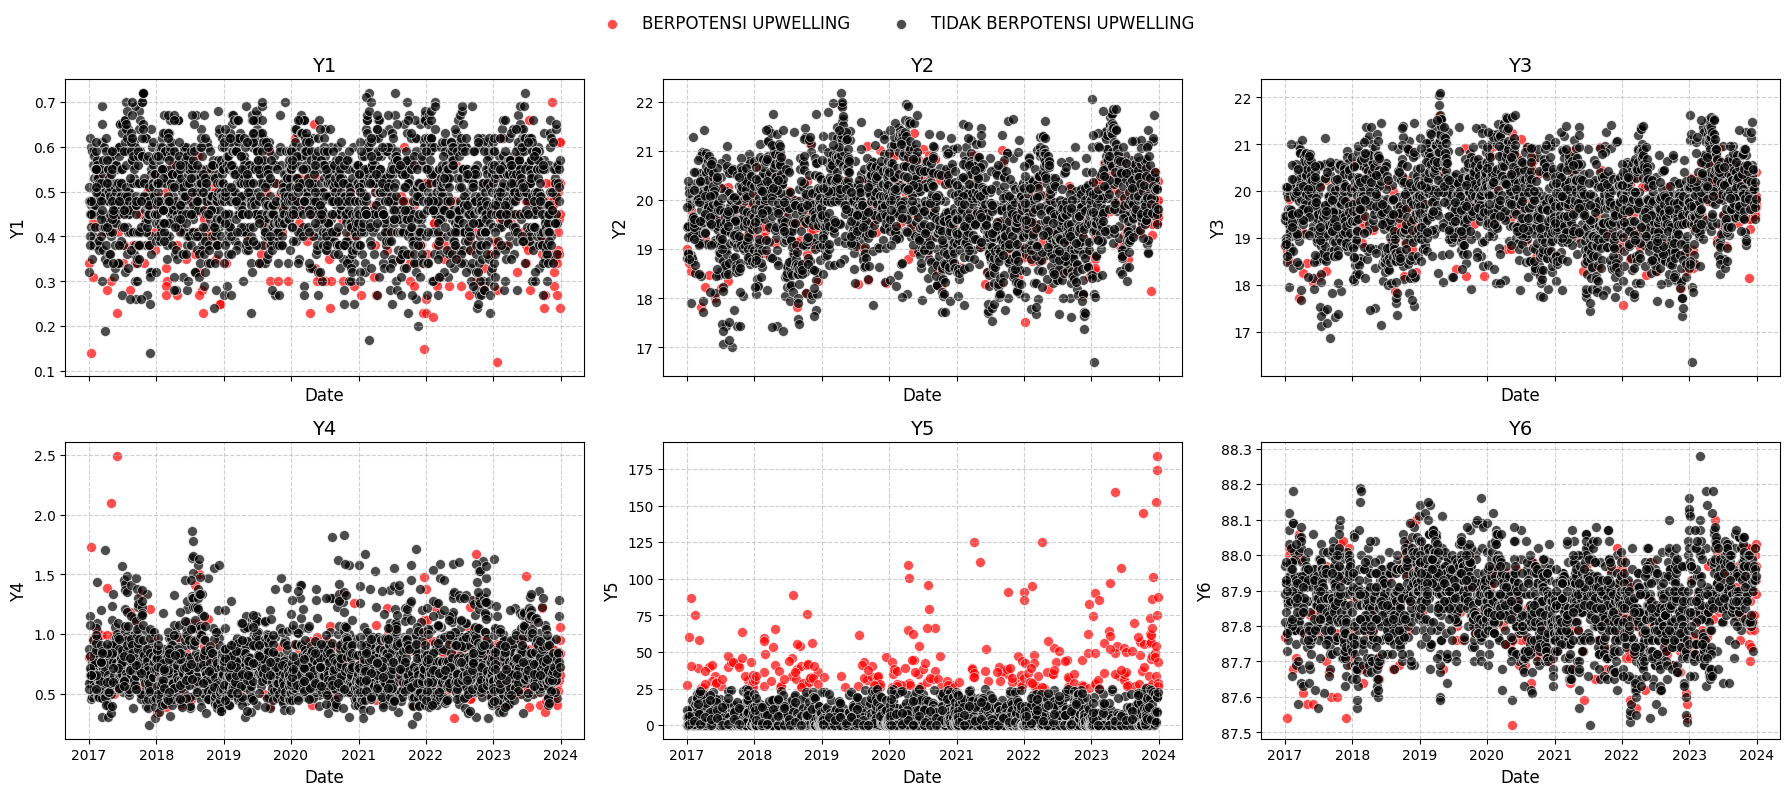

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert DATE to datetime
#data['DATE'] = pd.to_datetime(data['DATE'])

# Menentukan warna berdasarkan cluster
colors = {'BERPOTENSI UPWELLING': 'red', 'TIDAK BERPOTENSI UPWELLING': 'black'}

# Membuat plot
fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=True)
variables = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6"]
titles = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6"]

for ax, var, title in zip(axs.flatten(), variables, titles):
    for cluster in data['Cluster'].unique():
        cluster_data = data[data['Cluster'] == cluster]
        ax.scatter(cluster_data['DATE'], cluster_data[var],
                   color=colors[cluster], label=cluster, s=50, alpha=0.7, edgecolors='w', linewidth=0.5)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Menambahkan satu legenda untuk subplot pertama
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
#data = data.drop(columns=['DATE'])
#data.to_excel('HASIL_FIX.xlsx', index=False)

# KLASIFIKASI MODEL

In [ ]:
df = pd.read_excel('/content/HASIL_FIX.xlsx')
df.head(10)

,Y1,Y2,Y3,Y4,Y5,Y6,Cluster
0,0.34,19.01,18.83,0.81,27.45,87.77,BERPOTENSI UPWELLING
1,0.45,18.76,18.78,0.73,14.49,87.79,TIDAK BERPOTENSI UPWELLING
2,0.42,19.45,19.39,0.99,38.89,87.71,BERPOTENSI UPWELLING
3,0.19,17.95,17.90,1.70,15.65,87.64,TIDAK BERPOTENSI UPWELLING
4,0.30,18.47,18.47,2.10,40.10,87.58,BERPOTENSI UPWELLING
5,0.23,18.00,18.07,2.49,33.90,87.58,BERPOTENSI UPWELLING
6,0.27,18.54,18.59,1.57,17.60,87.57,TIDAK BERPOTENSI UPWELLING
7,0.45,17.44,17.44,1.01,11.02,87.61,TIDAK BERPOTENSI UPWELLING
8,0.48,17.01,16.86,1.14,0.53,87.68,TIDAK BERPOTENSI UPWELLING
9,0.68,17.44,17.32,1.05,0.00,87.76,TIDAK BERPOTENSI UPWELLING


In [ ]:
df.describe()

,Y1,Y2,Y3,Y4,Y5,Y6
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000
mean,0.482226,19.782320,19.693889,0.768627,9.053398,87.858959
std,0.097768,0.856408,0.827955,0.249939,16.130103,0.109279
min,0.120000,16.700000,16.350000,0.240000,0.000000,87.520000
25%,0.410000,19.220000,19.140000,0.590000,0.250000,87.790000
50%,0.480000,19.800000,19.720000,0.730000,2.740000,87.860000
75%,0.550000,20.390000,20.280000,0.890000,10.807500,87.940000
max,0.720000,22.190000,22.100000,2.490000,183.990000,88.280000


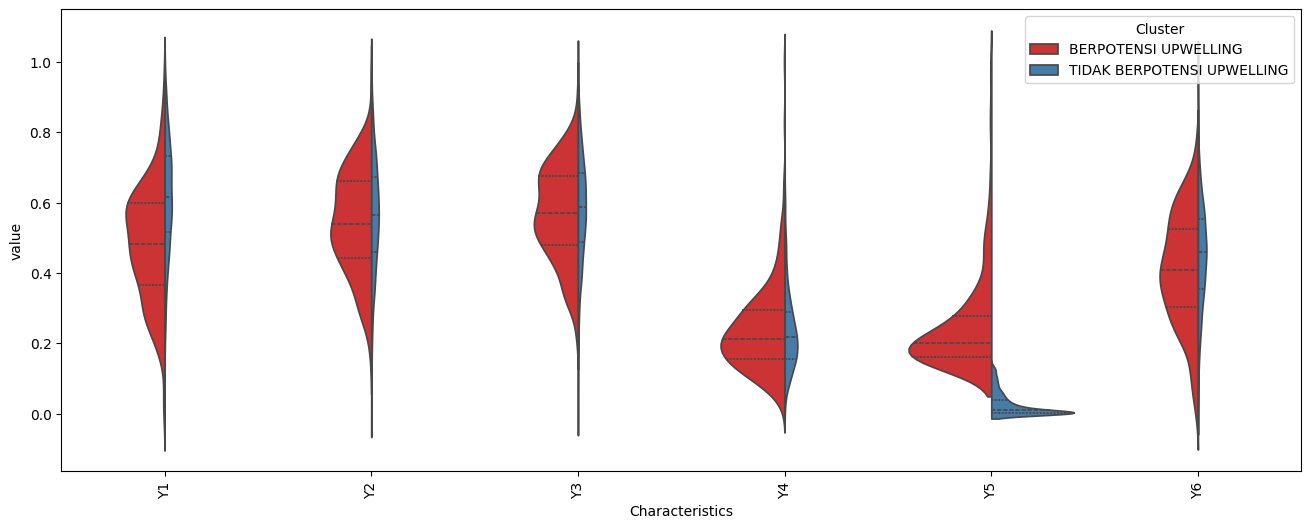

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_scaled = scaler.fit_transform(df_numeric)
df_norm = pd.DataFrame(df_scaled, columns=df_numeric.columns)
df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])
df_norm = pd.concat([df_norm, df_non_numeric.reset_index(drop=True)], axis=1)

# violin plot
df_violin = pd.melt(df_norm, "Cluster", var_name="Characteristics")
fig, ax = plt.subplots(figsize=(16,6))
plot_df = sns.violinplot(ax = ax, x="Characteristics", y="value", hue="Cluster", split = True, data=df_violin, inner = 'quartile', palette = 'Set1')
df_selain_class = df.drop(["Cluster"],axis = 1)
plot_df.set_xticklabels(rotation = 90, labels = list(df_selain_class.columns));

In [ ]:
# mengubah data object menjadi integer
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])

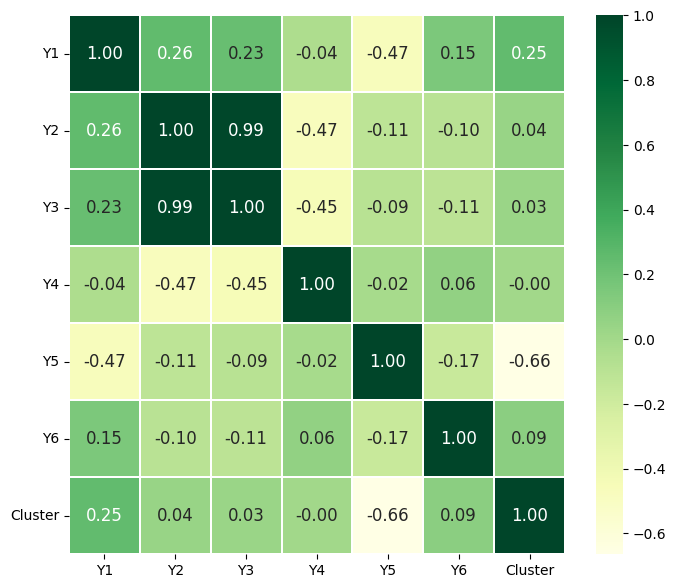

In [ ]:
# plot untuk melihat korelasi antar feature
plt.figure(figsize=(8,7))
sns.heatmap(df.corr(),linewidths=.2,cmap="YlGn",fmt=".2f",annot=True, annot_kws={"size": 12})
plt.yticks(rotation=0);

In [ ]:
X = df.drop(['Cluster'], axis=1)
y = df["Cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, stratify=y, random_state=0)

In [ ]:
# label untuk teks dibaca sebagai integer
lb = LabelEncoder()
lb.fit(y_train)

y_train = lb.transform(y_train)
y_test = lb.transform(y_test)


In [ ]:
X_train.describe()

,Y1,Y2,Y3,Y4,Y5,Y6
count,2044.000000,2044.000000,2044.000000,2044.000000,2044.000000,2044.000000
mean,32.166830,205.852740,205.516634,47.987280,383.233366,34.090509
std,9.803955,84.287956,81.984569,24.784017,390.449838,10.917307
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,25.000000,148.750000,149.000000,30.000000,26.000000,27.000000
50%,32.000000,207.000000,207.000000,44.000000,243.500000,35.000000
75%,39.000000,266.000000,264.250000,61.000000,677.000000,42.000000
max,56.000000,403.000000,392.000000,142.000000,1270.000000,67.000000


In [ ]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
y_test

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
X_train.head(19)

,Y1,Y2,Y3,Y4,Y5,Y6
77,26,74,80,42,170,53
437,50,309,265,39,268,34
588,33,42,55,125,1,36
565,29,58,69,137,277,43
1350,9,163,174,44,190,36
974,35,203,179,53,4,42
851,47,393,340,43,0,43
164,18,274,261,34,21,44
1784,36,184,192,30,586,15
1830,37,264,281,27,83,39


In [ ]:
#KERNEL LINEAR
#MODEL SVM
model = svm.SVC(kernel ='linear')
#train model pake data train
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 0 1 1 1 1 0 1 1 1 1 

In [ ]:
# model svm rbf
model2 = svm.SVC(kernel ='rbf')
#train model pake data train
model2.fit(X_train, y_train)
# predict data set pakai model sudah ditraining
y_pred2 = model2.predict(X_test)
print(y_pred2)

[0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 0 1 1 1 1 0 1 1 1 1 

In [ ]:
# model svm polinomial
model3 = svm.SVC(kernel ='poly')
#train model pake data train
model3.fit(X_train, y_train)
# predict data set pakai model sudah ditraining
y_pred3 = model3.predict(X_test)
print(y_pred3)

[0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 0 1 1 1 1 0 1 1 1 1 

In [ ]:
# model linear
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 51   3]
 [  1 457]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        54
           1       0.99      1.00      1.00       458

    accuracy                           0.99       512
   macro avg       0.99      0.97      0.98       512
weighted avg       0.99      0.99      0.99       512



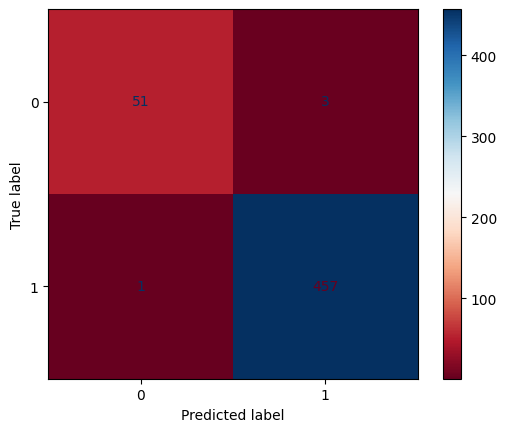

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=lb.classes_).plot(cmap = "RdBu")

In [ ]:
# model rbf
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

[[ 51   3]
 [  0 458]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        54
           1       0.99      1.00      1.00       458

    accuracy                           0.99       512
   macro avg       1.00      0.97      0.98       512
weighted avg       0.99      0.99      0.99       512



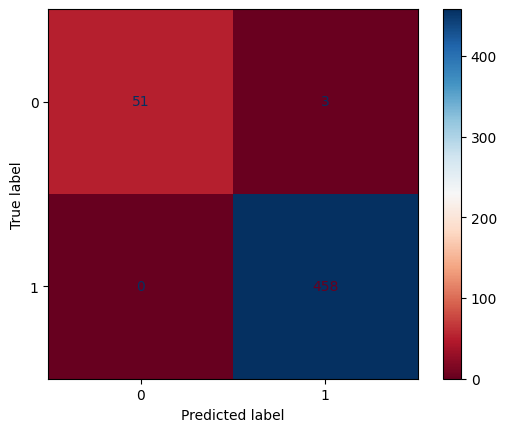

In [ ]:
cm = confusion_matrix(y_test, y_pred2)
ConfusionMatrixDisplay(cm, display_labels=lb.classes_).plot(cmap = "RdBu")

In [ ]:
# model polinomial
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

[[ 51   3]
 [  0 458]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        54
           1       0.99      1.00      1.00       458

    accuracy                           0.99       512
   macro avg       1.00      0.97      0.98       512
weighted avg       0.99      0.99      0.99       512



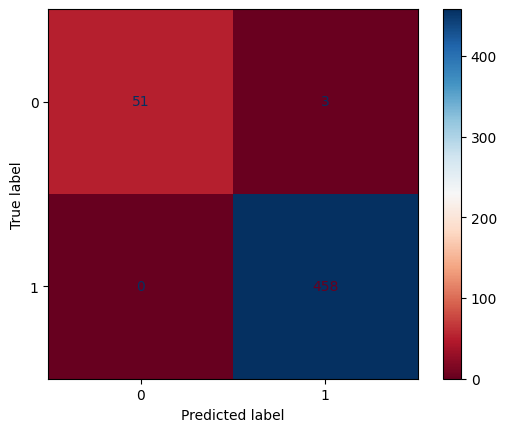

In [ ]:
cm = confusion_matrix(y_test, y_pred3)
ConfusionMatrixDisplay(cm, display_labels=lb.classes_).plot(cmap = "RdBu")

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd

# Misalkan X_train, y_train, X_test, dan y_test sudah didefinisikan sebelumnya

classifiers = [
    svm.SVC(kernel='linear'),
    svm.SVC(kernel='rbf'),
    svm.SVC(kernel='poly'),
]

# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("="*30)
    print(name)

    print('*Results*')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    log_entry = pd.DataFrame([[name, acc*100, 11]], columns=log_cols)
    log = pd.concat([log, log_entry], ignore_index=True)

    print("="*30)

print(log)


SVC
*Results*
Accuracy: 99.2188%
SVC
*Results*
Accuracy: 99.4141%
SVC
*Results*
Accuracy: 99.4141%
  Classifier   Accuracy Log Loss
0        SVC  99.218750       11
1        SVC  99.414062       11
2        SVC  99.414062       11


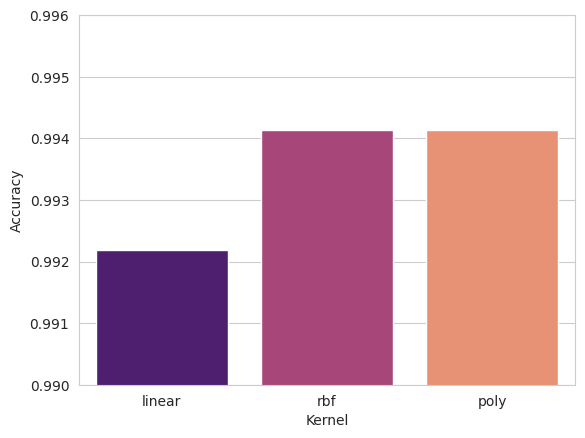

In [ ]:
# Data
kernels = ['linear', 'rbf', 'poly']
accuracy = [0.992188, 0.994141, 0.994141]

# Create bar plot
sns.set_style("whitegrid")
sns.barplot(x=kernels, y=accuracy, palette='magma')

# Set labels
plt.xlabel("Kernel")
plt.ylabel("Accuracy")

# Set y-axis scale from 98 to 100
plt.ylim(0.99, 0.996)

# Show plot
plt.show()

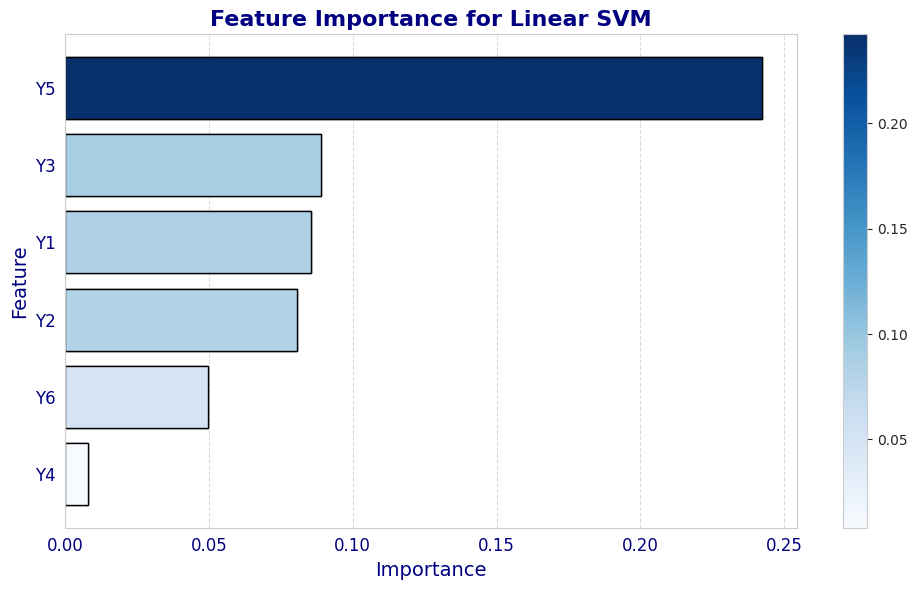

In [ ]:
# Ekstraksi koefisien dari model
feature_importance = np.abs(model.coef_[0])
feature_names = X.columns

# Membuat DataFrame untuk visualisasi
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Urutkan berdasarkan kepentingan fitur
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualisasi fitur penting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d', edgecolor='black')

# Custom colormap untuk semakin besar semakin pekat warna biru
norm = plt.Normalize(importance_df['Importance'].min(), importance_df['Importance'].max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])

# Warna semakin pekat untuk nilai penting yang lebih besar
plt.barh(importance_df['Feature'], importance_df['Importance'], color=plt.cm.Blues(norm(importance_df['Importance'])), edgecolor='black')

plt.title('Feature Importance for Linear SVM', fontsize=16, weight='bold', color='navy')
plt.xlabel('Importance', fontsize=14, color='navy')
plt.ylabel('Feature', fontsize=14, color='navy')
plt.xticks(fontsize=12, color='navy')
plt.yticks(fontsize=12, color='navy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.colorbar(sm, orientation='vertical')
plt.tight_layout()  # Mengoptimalkan layout untuk tampilan yang lebih baik
plt.show()
